# Capstone Project
## Probabilistic generative models
### Instructions

In this notebook, you will practice working with generative models, using both normalising flow networks and the variational autoencoder algorithm. You will create a synthetic dataset with a normalising flow with randomised parameters. This dataset will then be used to train a variational autoencoder, and you will use the trained model to interpolate between the generated images. You will use concepts from throughout this course, including Distribution objects, probabilistic layers, bijectors, ELBO optimisation and KL divergence regularisers.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports below. For this project you are free to make further imports throughout the notebook as you wish.

In [ ]:
# Setting keras 2.x as default for tensorflow probability compatibility
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"
import tf_keras as keras

In [ ]:
print(keras.__version__)

2.18.0


In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Additional imports
from sklearn.model_selection import train_test_split
from tf_keras.models import Sequential, Model
from tf_keras.layers import Flatten, BatchNormalization, UpSampling2D,\
  Reshape, Conv2D, Dense, InputLayer,Lambda,\
    Activation, Conv2DTranspose, LeakyReLU
from tf_keras.optimizers import Adam

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import matplotlib.animation as anim
from IPython.display import HTML

![Flags overview image](data/example_images.png)

For the capstone project, you will create your own image dataset from contour plots of a transformed distribution using a random normalising flow network. You will then use the variational autoencoder algorithm to train generative and inference networks, and synthesise new images by interpolating in the latent space.

#### The normalising flow
* To construct the image dataset, you will build a normalising flow to transform the 2-D Gaussian random variable $z=(z_1, z_2)$, which has mean $\mathbf{0}$ and covariance matrix $\Sigma=\sigma^2\mathbf{I}_2$, with $\sigma=0.3$.
* This normalising flow uses bijectors that are parameterised by the following random variables:
  * $\theta \sim U[0, 2\pi)$
  * $a \sim N(3, 1)$

The complete normalising flow is given by the following chain of transformations:

* $f_1(z) = (z_1, z_2 - 2)$,
* $f_2(z) = (z_1, \frac{z_2}{2})$,
* $f_3(z) = (z_1, z_2 + az_1^2)$,
* $f_4(z) = Rz$, where $R$ is a rotation matrix with angle $\theta$,
* $f_5(z) = \tanh(z)$, where the $\tanh$ function is applied elementwise.

The transformed random variable $x$ is given by $x = f_5(f_4(f_3(f_2(f_1(z)))))$.

* You should use or construct bijectors for each of the transformations $f_i$, $i=1,\ldots, 5$, and use `tfb.Chain` and `tfb.TransformedDistribution` to construct the final transformed distribution.
* Ensure to implement the `log_det_jacobian` methods for any subclassed bijectors that you write.
* Display a scatter plot of samples from the base distribution.
* Display 4 scatter plot images of the transformed distribution from your random normalising flow, using samples of $\theta$ and $a$. Fix the axes of these 4 plots to the range $[-1, 1]$.

In [ ]:
# Base isotropic 2D Gaussia1n for normalizing flow
z = tfd.MultivariateNormalDiag(loc=tf.zeros(2), scale_diag=tf.ones(2)*0.3)

# Distributions that parameterise bijectors
uniform = tfd.Uniform(low=0, high=2*np.pi)
normal = tfd.Normal(loc=3, scale=1)

In [ ]:
# Class definition of f3(z) bijector
class F3(tfb.Bijector):
  def __init__(self, a, validate_args=False, **kwargs):
    self.a = tf.cast(a, tf.float32)
    super(F3, self).__init__(validate_args=validate_args,
                             forward_min_event_ndims=1)

  def _forward(self, x):
    x = tf.cast(x, tf.float32)
    return tf.stack([x[..., 0], x[..., 1] + self.a * x[..., 0]**2], axis=-1)

  def _inverse(self, y):
    y = tf.cast(y, tf.float32)
    return tf.stack([y[..., 0], y[..., 1]- self.a * y[..., 0]**2], axis=-1)

  def _inverse_log_det_jacobian(self, y):
    return tf.constant(0, dtype=tf.float32)

  def _forward_log_det_jacobian(self, x):
    return tf.constant(0, dtype=tf.float32)
    return tf.constant(0, dtype=tf.float32)

In [ ]:
# Class definition of f4(z) bijector
class F4(tfb.Bijector):
  def __init__(self, theta, validate_args=False, **kwargs):
    theta = tf.cast(theta, tf.float32)
    self.r_matrix = tf.convert_to_tensor([[tf.cos(theta), -tf.sin(theta)],
                                 [tf.sin(theta), tf.cos(theta)]],
                                 dtype=tf.float32)
    super(F4, self).__init__(
        validate_args=validate_args,
        forward_min_event_ndims=1,)

  def _forward(self, x):
      x = tf.cast(x, tf.float32)
      return tf.linalg.matvec(self.r_matrix, x)

  def _inverse(self, y):
      y = tf.cast(y, tf.float32)
      return tf.linalg.matvec(tf.transpose(self.r_matrix), y)

  def _inverse_log_det_jacobian(self,y):
      return tf.constant(0, dtype=tf.float32)

  def _forward_log_det_jacobian(self, x):
      return tf.constant(0, dtype=tf.float32)

In [ ]:
# Chained bijector function
def get_bijector(a, theta):
  f1 = tfb.Shift([0, -2])
  f2 = tfb.Scale([1, 0.5])
  f3 = F3(a)
  f4 = F4(theta)
  f5 = tfb.Tanh()
  bijector = tfb.Chain([f5, f4, f3, f2, f1])
  return bijector

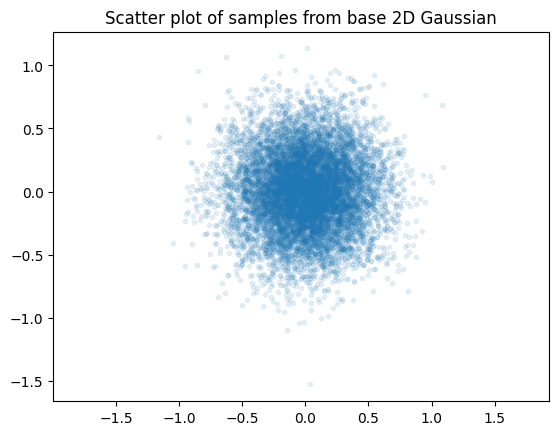

In [ ]:
# Samples and scatter plot from base 2D Gaussian
n_samples = 10000

z_sample = z.sample(n_samples).numpy()

plt.scatter(z_sample[:, 0], z_sample[:, 1], marker='.', alpha=0.1)
plt.title('Scatter plot of samples from base 2D Gaussian')
plt.axis('equal')
plt.show()

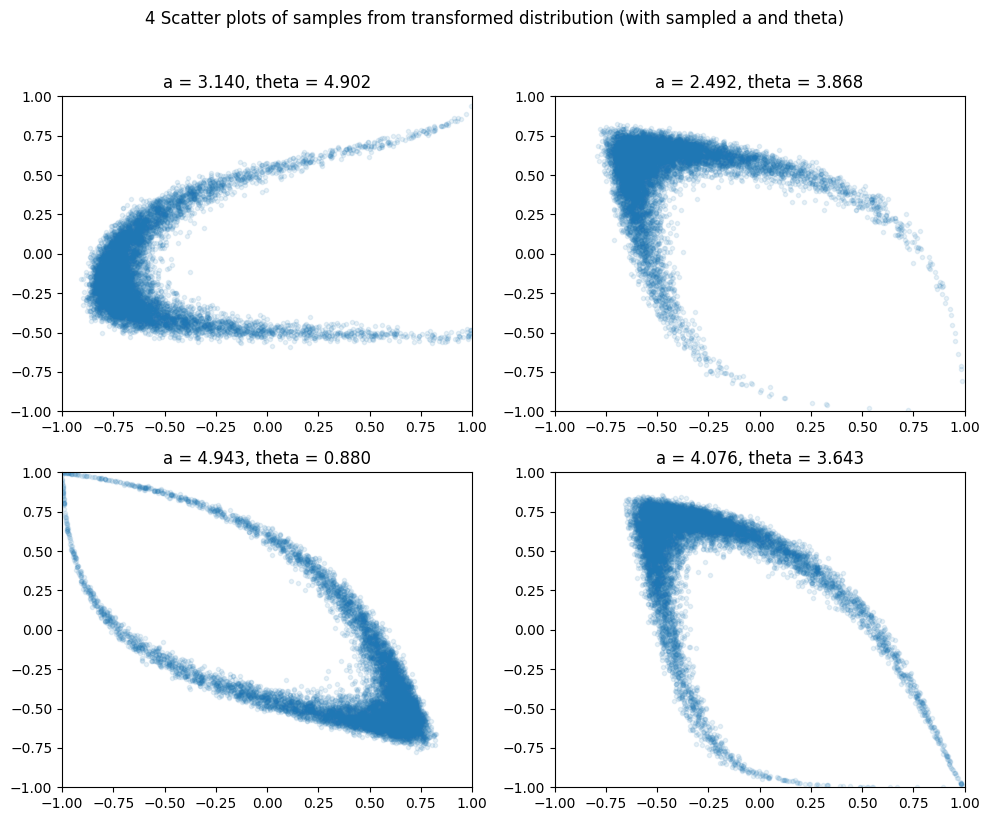

In [ ]:
# Scatter plots of samples from transformed distribution
# 4 sets of 10,000 samples resampling a and theta for each set
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

for i in range(4):
    a = normal.sample()
    theta = uniform.sample()
    f_bijector = get_bijector(a, theta)
    dist = tfd.TransformedDistribution(distribution=z, bijector=f_bijector)
    dist_sample = dist.sample(n_samples).numpy()
    axs[i//2, i%2].scatter(
        dist_sample[:,0], dist_sample[:,1], marker='.', alpha=0.1)
    axs[i//2, i%2].set_xlim([-1, 1])
    axs[i//2, i%2].set_ylim([-1, 1])
    axs[i//2, i%2].set_title('a = {:.3f}, theta = {:.3f}'.format(a, theta))
fig.suptitle(
    '4 Scatter plots of samples from transformed distribution (with sampled a and theta)', y=1.02)
plt.tight_layout()
plt.show()

## 2. Create the image dataset
* You should now use your random normalising flow to generate an image dataset of contour plots from your random normalising flow network.
  * Feel free to get creative and experiment with different architectures to produce different sets of images!
* First, display a sample of 4 contour plot images from your normalising flow network using 4 independently sampled sets of parameters.
  * You may find the following `get_densities` function useful: this calculates density values for a (batched) Distribution for use in a contour plot.
* Your dataset should consist of at least 1000 images, stored in a numpy array of shape `(N, 36, 36, 3)`.  Each image in the dataset should correspond to a contour plot of a transformed distribution from a normalising flow with an independently sampled set of parameters $s, T, S, b$. It will take a few minutes to create the dataset.
* As well as the `get_densities` function, the `get_image_array_from_density_values` function will help you to generate the dataset.
  * This function creates a numpy array for an image of the contour plot for a given set of density values Z. Feel free to choose your own options for the contour plots.
* Display a sample of 20 images from your generated dataset in a figure.

In [ ]:
# Helper function to compute transformed distribution densities

X, Y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
inputs = np.transpose(np.stack((X, Y)), [1, 2, 0])

def get_densities(transformed_distribution):
    """
    This function takes a (batched) Distribution object as an argument, and returns a numpy
    array Z of shape (batch_shape, 100, 100) of density values, that can be used to make a
    contour plot with:
    plt.contourf(X, Y, Z[b, ...], cmap='hot', levels=100)
    where b is an index into the batch shape.
    """
    batch_shape = transformed_distribution.batch_shape
    Z = transformed_distribution.prob(np.expand_dims(inputs, 2))
    Z = np.transpose(Z, list(range(2, 2+len(batch_shape))) + [0, 1])

    return Z

In [ ]:
# Helper function to convert contour plots to numpy arrays

def get_image_array_from_density_values(Z):
    """
    This function takes a numpy array Z of density values of shape (100, 100)
    and returns an integer numpy array of shape (36, 36, 3) of pixel values for an image.
    """
    assert Z.shape == (100, 100)
    fig = Figure(figsize=(0.36, 0.36))
    canvas = FigureCanvas(fig)
    ax = fig.gca()
    ax.contourf(X, Y, Z, cmap='hot', levels=100)
    ax.axis('off')
    fig.tight_layout(pad=0)

    ax.margins(0)
    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(
        fig.canvas.get_width_height()[::-1] + (4,))

    #addded line to make it work with new version of matplotlib
    image_from_plot_rgb = image_from_plot[..., [1, 2, 3, 0]][..., :3]

    return image_from_plot_rgb

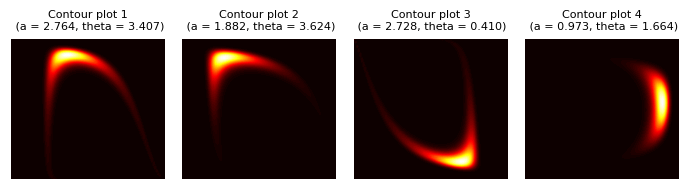

In [ ]:
# Contour plots images of 4 samples from normalizaing flow
# with independent sample sets of parameters
fig, axs = plt.subplots(1, 4, figsize=(7, 2))

for i in range(4):
  a = normal.sample()
  theta = uniform.sample()
  f_bijector = get_bijector(a, theta)
  dist = tfd.TransformedDistribution(distribution=z, bijector=f_bijector)
  batch_dist = tfd.BatchReshape(dist, [1])
  Z = get_densities(batch_dist)
  axs[i%4].contourf(X, Y, Z[0,...], cmap='hot', levels=100)
  axs[i%4].set_title(
      'Contour plot {:d}\n (a = {:.3f}, theta = {:.3f})'.format(i+1,
          a, theta), fontsize=8)
  axs[i%4].axis('off')
fig.tight_layout()
plt.show()


In [ ]:
# Creation of the images dataset
number_images = 5000
image_shape = (36, 36, 3)
images = np.empty((number_images, *image_shape), dtype=np.uint8)

for i in range(number_images):
    a = normal.sample()
    theta = uniform.sample()
    f_bijector = get_bijector(a, theta)
    dist = tfd.TransformedDistribution(distribution=z, bijector=f_bijector)
    batch_dist = tfd.BatchReshape(dist, [1])
    Z = get_densities(batch_dist).squeeze()
    images[i, ...] = get_image_array_from_density_values(Z)

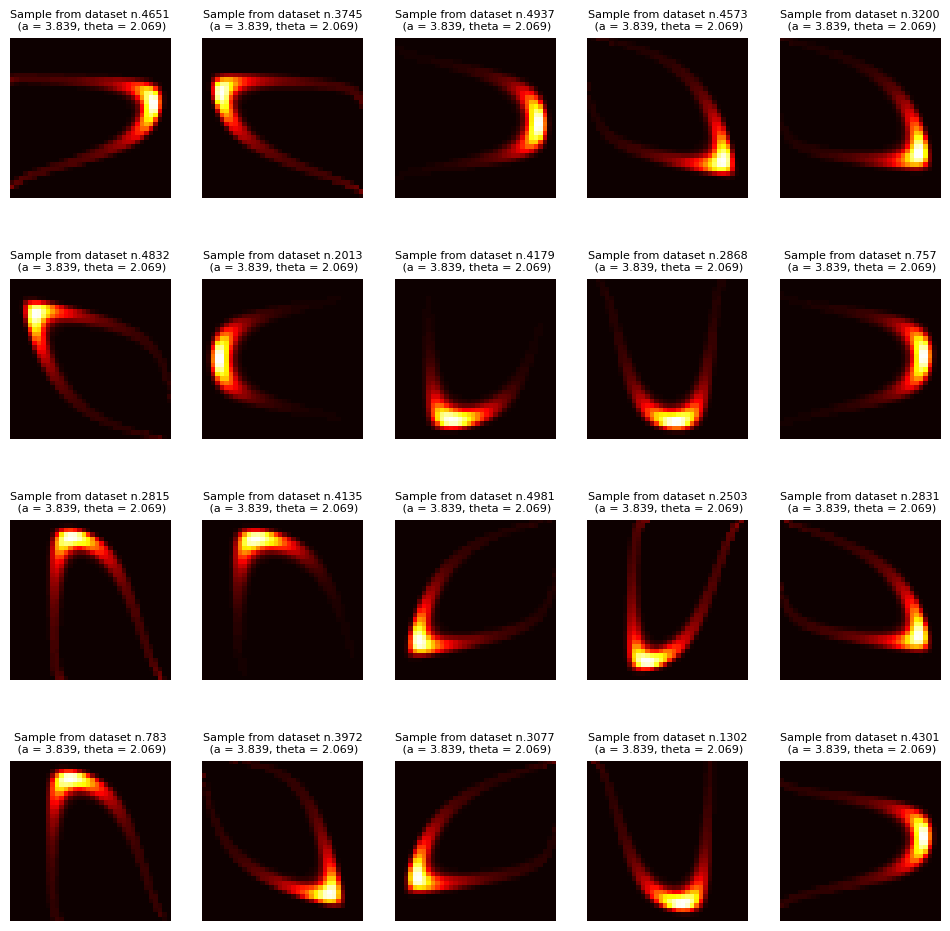

In [ ]:
# Display 20 random samples from images dataset
indx = np.random.choice(number_images, 20)
fig, axs = plt.subplots(4, 5, figsize=(12,12))
for i in range(20):
    axs[i//5, i%5].imshow(images[indx[i]])
    axs[i//5, i%5].axis('off')
    axs[i//5, i%5].set_title(
      'Sample from dataset n.{:d}\n (a = {:.3f}, theta = {:.3f})'.format(indx[i],
            a, theta), fontsize = 8)
plt.show()

## 3. Make `tf.data.Dataset` objects
* You should now split your dataset to create `tf.data.Dataset` objects for training and validation data.
* Using the `map` method, normalise the pixel values so that they lie between 0 and 1.
* These Datasets will be used to train a variational autoencoder (VAE). Use the `map` method to return a tuple of input and output Tensors where the image is duplicated as both input and output.
* Randomly shuffle the training Dataset.
* Batch both datasets with a batch size of 20, setting `drop_remainder=True`.
* Print the `element_spec` property for one of the Dataset objects.

In [ ]:
# Split of images dataset into training and validation sets
train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
val_dataset = tf.data.Dataset.from_tensor_slices(val_images)

In [ ]:
# Datasets normalization
def rescale(image):
  return tf.cast(image, tf.float32)/255.

train_dataset = train_dataset.map(rescale)
val_dataset = val_dataset.map(rescale)

In [ ]:
# Duplicate each image to be also output in the datasets
train_dataset = train_dataset.map(lambda x: (x,x))
val_dataset = val_dataset.map(lambda x: (x,x))

In [ ]:
# Shuffle and batch datasets
train_dataset = train_dataset.shuffle(buffer_size=100)
train_dataset_batched = train_dataset.batch(20, drop_remainder=True)
val_dataset_batched = val_dataset.batch(20, drop_remainder=True)

In [ ]:
# ptint element.spec for training dataset
train_dataset_batched.element_spec

(TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float32, name=None))

## 4. Build the encoder and decoder networks
* You should now create the encoder and decoder for the variational autoencoder algorithm.
* You should design these networks yourself, subject to the following constraints:
   * The encoder and decoder networks should be built using the `Sequential` class.
   * The encoder and decoder networks should use probabilistic layers where necessary to represent distributions.
   * The prior distribution should be a zero-mean, isotropic Gaussian (identity covariance matrix).
   * The encoder network should add the KL divergence loss to the model.
* Print the model summary for the encoder and decoder networks.

In [ ]:
# Definition of prior, latent space dimensionality and event shape
latent_size = 2
event_shape = (36, 36, 3)

prior = tfd.MultivariateNormalDiag(loc=tf.zeros(latent_size))

In [ ]:
# Encoder definition through a Sequential
# Using LeakyReLU to improve convergence and reduce vanishing gradient
encoder = Sequential([
    Conv2D(32, 3, padding='same', input_shape=event_shape),
    BatchNormalization(),
    LeakyReLU(0.01),

    Conv2D(64, 3, padding='same'),
    BatchNormalization(),
    LeakyReLU(0.01),

    Conv2D(128, 3, padding='same'),
    BatchNormalization(),
    LeakyReLU(0.01),

    Conv2D(256, 3, padding='same'),
    BatchNormalization(),
    LeakyReLU(0.01),

    Flatten(),
    Dense(128),
    LeakyReLU(0.01),

    Dense(64,),
    LeakyReLU(0.01),

    Dense(32),
    LeakyReLU(0.01),

    Dense(tfpl.MultivariateNormalTriL.params_size(latent_size)),

    tfpl.MultivariateNormalTriL(event_size=latent_size),
    tfpl.KLDivergenceAddLoss(prior)
])

# Print encoder summary
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 36, 36, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 36, 36, 32)        128       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 36, 36, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 36, 36, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 36, 36, 64)        256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 36, 36, 64)        0

In [ ]:
# Test and verify shape of encoder output
input_batch = next(iter(train_dataset_batched))
encoder_output = encoder(input_batch[0])
encoder_output

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[20] event_shape=[2] dtype=float32>

In [ ]:
# Verify KL Divergence is being calculated
encoder.losses

[<tf.Tensor: shape=(), dtype=float32, numpy=0.2576541602611542>]

In [ ]:
# Decoder definition through Sequential
decoder = Sequential([
    Dense(4 * 4 * 1024, activation='relu', input_shape=(latent_size,)),
    Reshape((4, 4, 1024)),

    # First upsampling: (4, 4) -> (8, 8)
    Conv2DTranspose(512, 4, strides=(2, 2), padding='same'),
    BatchNormalization(),
    LeakyReLU(0.1),

    # Second upsampling: (8, 8) -> (16, 16)
    Conv2DTranspose(256, 4, strides=(2, 2), output_padding=1, padding='same'),
    BatchNormalization(),
    LeakyReLU(0.1),

    # Third upsampling: (16, 16) -> (32, 32)
    Conv2DTranspose(128, 4, strides=(2, 2), output_padding=1, padding='valid'),
    BatchNormalization(),
    LeakyReLU(0.1),

    # Fine-tuning step: (32, 32) -> (35, 35)
    Conv2DTranspose(64, 4, strides=(1, 1), padding='valid'),
    BatchNormalization(),
    LeakyReLU(0.1),

    # Final adjustment: (35, 35) -> (36, 36)
    Conv2D(3, 3, strides=(1, 1), padding='same'),  # Adjust padding to match target shape
    Flatten(),

    tfpl.IndependentBernoulli(event_shape=event_shape)
])
# Print decoder summary
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 16384)             49152     
                                                                 
 reshape (Reshape)           (None, 4, 4, 1024)        0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 512)         8389120   
 anspose)                                                        
                                                                 
 batch_normalization_4 (Bat  (None, 8, 8, 512)         2048      
 chNormalization)                                                
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 15, 15, 256)      

In [ ]:
# Test decoder for correct output shape
decoder(tf.random.uniform([1, latent_size]))

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[36, 36, 3] dtype=float32>

## 5. Train the variational autoencoder
* You should now train the variational autoencoder. Build the VAE using the `Model` class and the encoder and decoder models. Print the model summary.
* Compile the VAE with the negative log likelihood loss and train with the `fit` method, using the training and validation Datasets.
* Plot the learning curves for loss vs epoch for both training and validation sets.

In [ ]:
# Build VAE model through model class  and print summary
vae = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))
vae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 36, 36, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 36, 36, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 36, 36, 32)        128       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 36, 36, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 36, 36, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 36, 36, 64)        256       
 chNormalization)                                            

In [ ]:
# Define function that calculates reconstruction loss
def reconstruction_loss(batch_of_images, decod_dist):
  return -tf.reduce_mean(decod_dist.log_prob(batch_of_images))

In [ ]:
# Compile model
optimizer = Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer, loss=reconstruction_loss)

In [ ]:
# Fit the model
history = vae.fit(train_dataset_batched, validation_data=val_dataset_batched, epochs=20, verbose=1)

Epoch 1/20
200/200 [==============================] - 22s 69ms/step - loss: 739.2812 - val_loss: 691.1982
Epoch 2/20
200/200 [==============================] - 13s 66ms/step - loss: 452.9877 - val_loss: 593.3066
Epoch 3/20
200/200 [==============================] - 13s 66ms/step - loss: 411.4109 - val_loss: 410.2269
Epoch 4/20
200/200 [==============================] - 13s 67ms/step - loss: 396.7329 - val_loss: 397.6695
Epoch 5/20
200/200 [==============================] - 13s 65ms/step - loss: 392.0515 - val_loss: 388.0997
Epoch 6/20
200/200 [==============================] - 13s 66ms/step - loss: 389.2210 - val_loss: 382.7697
Epoch 7/20
200/200 [==============================] - 13s 67ms/step - loss: 384.3594 - val_loss: 388.6471
Epoch 8/20
200/200 [==============================] - 13s 66ms/step - loss: 381.5597 - val_loss: 391.6981
Epoch 9/20
200/200 [==============================] - 13s 66ms/step - loss: 380.4270 - val_loss: 381.8698
Epoch 10/20
200/200 [=========================

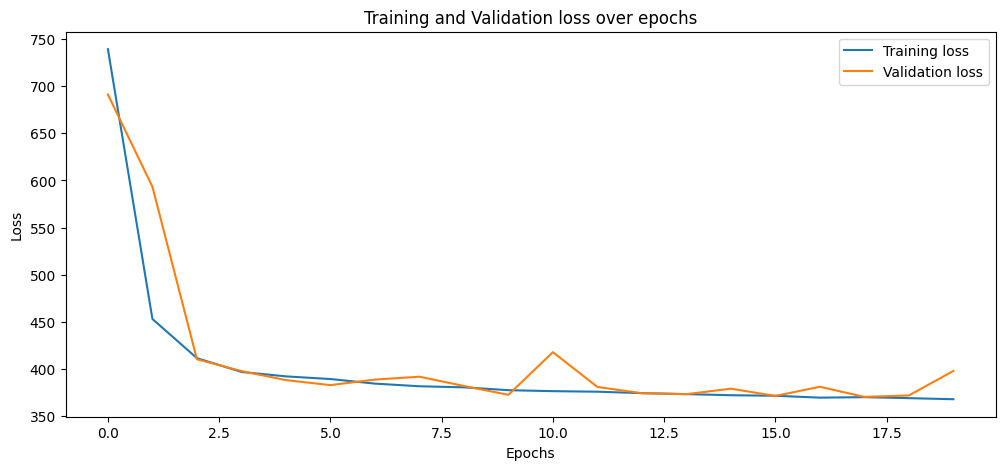

In [ ]:
# Plot Training and Validation losses after training the model
fig, axs = plt.subplots(figsize=(12,5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation loss over epochs')
plt.show()

## 6. Use the encoder and decoder networks
* You can now put your encoder and decoder networks into practice!
* Randomly sample 1000 images from the dataset, and pass them through the encoder. Display the embeddings in a scatter plot (project to 2 dimensions if the latent space has dimension higher than two).
* Randomly sample 4 images from the dataset and for each image, display the original and reconstructed image from the VAE in a figure.
  * Use the mean of the output distribution to display the images.
* Randomly sample 6 latent variable realisations from the prior distribution, and display the images in a figure.
  * Again use the mean of the output distribution to display the images.

In [ ]:
# Define function to sample images from dataset
np.random.seed(42)

def get_sample_images(sample_size):
    indx = np.random.choice(
        number_images, sample_size, replace = False)
    sample_images = images[indx]/255.
    return sample_images

In [ ]:
# Sample images to pass through encoder
n_images_scatter = 1000

sample_images_scatter = np.array(get_sample_images(n_images_scatter))
sample_images_scatter.shape

(1000, 36, 36, 3)

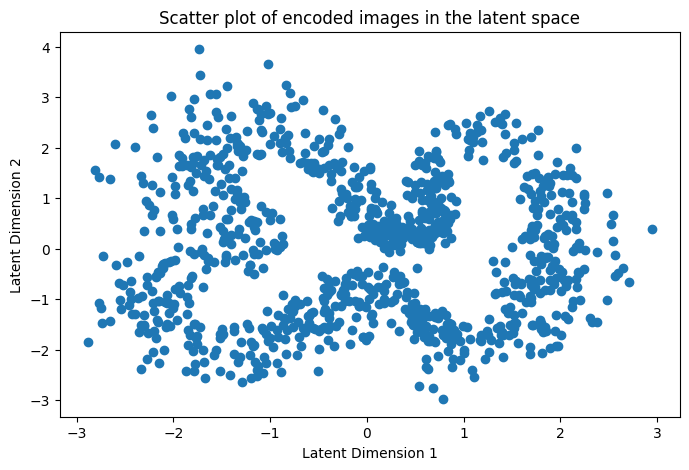

In [ ]:
# Scatter plot of encoded images
encoded_images = encoder(sample_images_scatter)

fig ,axs = plt.subplots(figsize=(8,5))
axs.scatter(encoded_images[:,0], encoded_images[:,1])
plt.title('Scatter plot of encoded images in the latent space')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()

In [ ]:
# Sample images to test model reconstruction
n_images_reconstruct = 4

sample_images = np.array(get_sample_images(n_images_reconstruct))
sample_images.shape

sample_images_reconstr = vae(sample_images).mean()

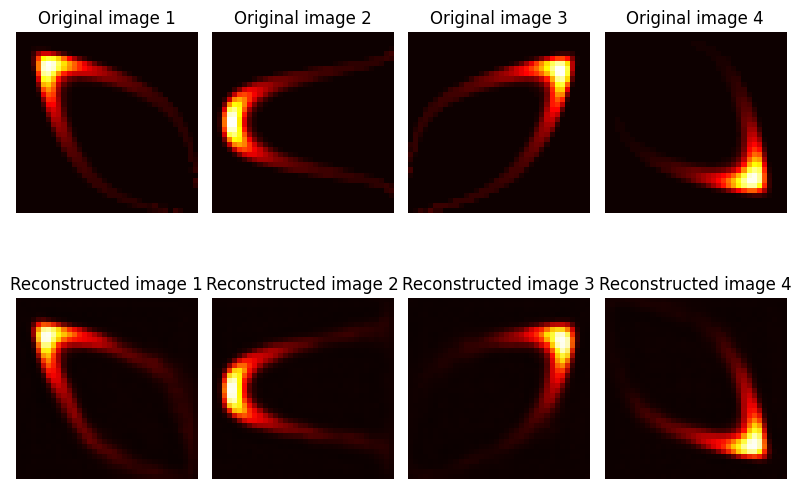

In [ ]:
# Display original and reconstructed images
fig, axs = plt.subplots(2, n_images_reconstruct, figsize=(8, 6))
for t in range(n_images_reconstruct):
  axs[0, t].imshow(sample_images[t])
  axs[0, t].set_title(f'Original image {t+1}')
  axs[0, t].axis('off')
  axs[1, t].imshow(sample_images_reconstr[t])
  axs[1, t].set_title(f'Reconstructed image {t+1}')
  axs[1, t].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Sample of latent variables from prior and pass through decoder
latent_samples = prior.sample(6)

decoded_prior_samples = decoder(latent_samples).mean()

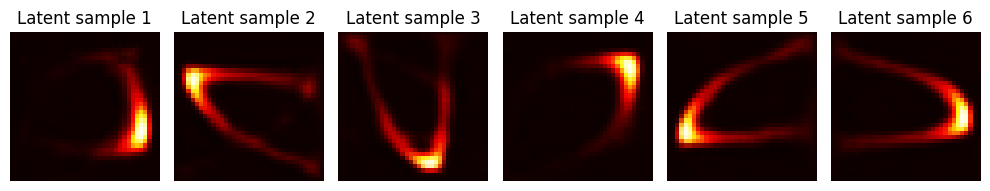

In [ ]:
# Plot the reconstructions of latent samples
fig, axs = plt.subplots(1, 6, figsize=(10,6))
for t in range(6):
    axs[t].imshow(decoded_prior_samples[t])
    axs[t].set_title(f'Latent sample {t+1}')
    axs[t].axis('off')
plt.tight_layout()

## Make a video of latent space interpolation (not assessed)
* Just for fun, you can run the code below to create a video of your decoder's generations, depending on the latent space.

In [ ]:
# Function to create animation

import matplotlib.animation as anim
from IPython.display import HTML


def get_animation(latent_size, decoder, interpolation_length=500):
    assert latent_size >= 2, "Latent space must be at least 2-dimensional for plotting"
    fig = plt.figure(figsize=(9, 4))
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_xlim([-3, 3])
    ax1.set_ylim([-3, 3])
    ax1.set_title("Latent space")
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title("Data space")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)

    # initializing a line variable
    line, = ax1.plot([], [], marker='o')
    img2 = ax2.imshow(np.zeros((36, 36, 3)))

    freqs = np.random.uniform(low=0.1, high=0.2, size=(latent_size,))
    phases = np.random.randn(latent_size)
    input_points = np.arange(interpolation_length)
    latent_coords = []
    for i in range(latent_size):
        latent_coords.append(2 * np.sin((freqs[i]*input_points + phases[i])).astype(np.float32))

    def animate(i):
        z = tf.constant([coord[i] for coord in latent_coords])
        img_out = np.squeeze(decoder(z[np.newaxis, ...]).mean().numpy())
        line.set_data([z.numpy()[0]], [z.numpy()[1]])
        img2.set_data(np.clip(img_out, 0, 1))
        return (line, img2)

    return anim.FuncAnimation(fig, animate, frames=interpolation_length,
                              repeat=False, blit=True, interval=150)

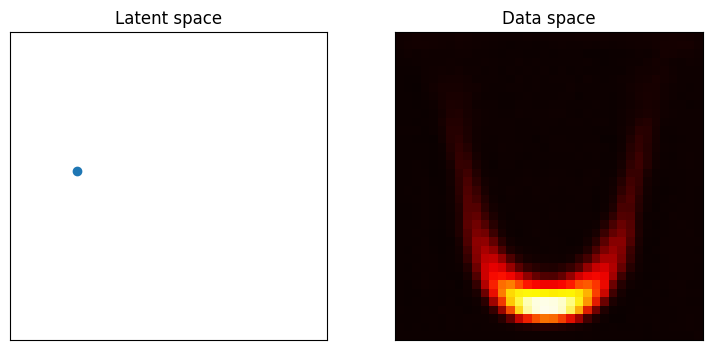

In [ ]:
# Create the animation

a = get_animation(latent_size, decoder, interpolation_length=200)
HTML(a.to_html5_video())